In [7]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import anndata
import scanpy as sc
from sklearn.metrics.pairwise import cosine_similarity
import ruptures as rpt

In [38]:
dataset = 'BF'

In [40]:
exp_data = pd.read_csv('/home/chloe/coexp_change/datasets/dyn-{}-2000-1/ExpressionData.csv'.format(dataset), index_col=0).T
time_data = pd.read_csv('/home/chloe/coexp_change/datasets/dyn-{}-2000-1/PseudoTime.csv'.format(dataset), index_col=0)
if dataset in ['LI', 'LL']:
    data = exp_data.join(time_data).sort_values(by='PseudoTime')
    data['Lineage'] = 0
else:
    data = exp_data.join(time_data)
    sub_data_list = []
    ptime_cols = data.filter(regex=("PseudoTime*")).columns
    for i, c in enumerate(ptime_cols):
        data_i = data[~data[c].isnull()]
        data_i['PseudoTime'] = data_i[c].copy()
        data_i = data_i.drop(columns=ptime_cols)
        data_i['Lineage'] = i
        sub_data_list.append(data_i)
    data = pd.concat(sub_data_list).sort_values(by=['Lineage', 'PseudoTime'])

/home/chloe/.conda/envs/semantic/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


In [41]:
if dataset == 'LI':
    df_vocab_DiffTime = pd.read_csv('/home/chloe/coexp_change/models/LI_2000_1_128_64_DiffTime_Dec08-11-45/vocab.csv')
    df_vocab_ExpEst = pd.read_csv('/home/chloe/coexp_change/models/LI_2000_1_128_ExpEstimator_Dec08-12-01/vocab.csv')
elif dataset == 'BF':
    df_vocab_DiffTime = pd.read_csv('/home/chloe/coexp_change/models/BF_2000_1_128_64_DiffTime_Dec07-22-57/vocab.csv')
    df_vocab_ExpEst = pd.read_csv('/home/chloe/coexp_change/models/BF_2000_1_128_ExpEstimator_Dec08-12-21/vocab.csv')
elif dataset == 'TF':
    df_vocab_DiffTime = pd.read_csv('/home/chloe/coexp_change/models/TF_2000_1_128_64_DiffTime_Dec07-23-28/vocab.csv')
    df_vocab_ExpEst = pd.read_csv('/home/chloe/coexp_change/models/TF_2000_1_128_ExpEstimator_Dec08-12-11/vocab.csv')

In [42]:
df_vocab_DiffTime.columns = ['index', 'gene']
df_vocab_ExpEst.columns = ['index', 'gene']

In [43]:
vocab_size = len(data.columns[:-2])
print(vocab_size)

7


/home/chloe/.conda/envs/semantic/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


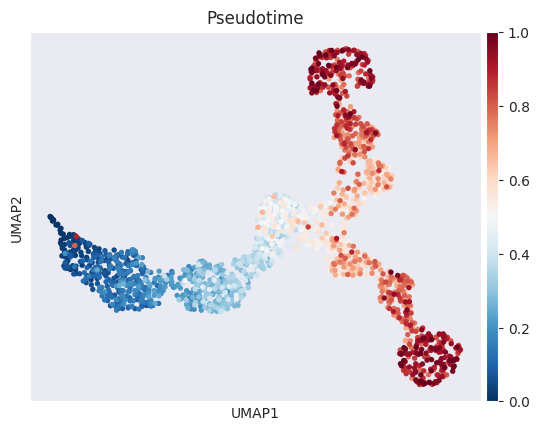

In [44]:
adata = anndata.AnnData(data.iloc[:, :-2])
adata.obs_names = list(data.index)
adata.var_names = list(data.columns[:-2])
sc.pp.neighbors(adata)
adata.obs['Pseudotime'] = list(data.PseudoTime)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["Pseudotime"], color_map='RdBu_r')

In [45]:
DiffTime_hyperparameter = {
'embed_dim': 128,
'embed_max_norm': 1,
'h1_dim': 64,
'h2_dim': 64,
'output_dim': 128,
'prod_dim': 64,
'num_add_layer': 0,
'activation': 'relu',
}

In [46]:
class DiffTime(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size, embed_dim, output_dim, h1_dim, h2_dim, prod_dim, embed_max_norm=1.0):
        super(DiffTime, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.output_dim = output_dim
        self.h1_dim = h1_dim
        self.h2_dim = h2_dim
        self.prod_dim = prod_dim
        self.embed_max_norm = embed_max_norm

        self.cont_embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            max_norm=embed_max_norm,
        )

        # Encode exp val as a function of time
        self.time_vec_h1 = nn.Linear(
            in_features=2,
            out_features=self.h1_dim,
        )

        if DiffTime_hyperparameter['num_add_layer'] == 1:
            self.time_vec_h2 = nn.Linear(
                in_features=self.h1_dim,
                out_features=self.h1_dim,
            )
        elif DiffTime_hyperparameter['num_add_layer'] == 2:
            self.time_vec_h2 = nn.Linear(
                in_features=self.h1_dim,
                out_features=self.h1_dim,
            )

            self.time_vec_h3 = nn.Linear(
                in_features=self.h1_dim,
                out_features=self.h1_dim,
            )

        self.time_vec_h4 = nn.Linear(
            in_features=self.h1_dim,
            out_features=self.h2_dim,
        )

        # Encode emb to matrix
        self.emb_to_mat = nn.Linear(
            in_features=self.embed_dim,
            out_features=self.h2_dim * self.prod_dim,
        )

        # Last linear layer
        self.linear = nn.Linear(
            in_features=self.prod_dim,
            out_features=self.output_dim,
        )
        
        self.m = nn.Sigmoid()
        if DiffTime_hyperparameter['activation'] == 'relu':
            self.r = nn.ReLU()
        elif DiffTime_hyperparameter['activation'] == 'tanh':
            self.r = nn.Tanh()

    def forward(self, inputs, targets, t, lineage):
        # Encode time and context gene identity in a vector t_i
        t_i_cont = torch.cat([t.unsqueeze(1), lineage.unsqueeze(1)], 1).unsqueeze(1)
        t_i_cont = self.r(self.time_vec_h1(t_i_cont))
        if DiffTime_hyperparameter['num_add_layer'] == 1:
            t_i_cont = self.r(self.time_vec_h2(t_i_cont))
        if DiffTime_hyperparameter['num_add_layer'] == 2:
            t_i_cont = self.r(self.time_vec_h2(t_i_cont))
            t_i_cont = self.r(self.time_vec_h3(t_i_cont))
        t_i_cont = self.r(self.time_vec_h4(t_i_cont))

        # Encode cont emb
        x_cont = self.cont_embeddings(inputs)
        x_cont = self.emb_to_mat(x_cont)
        x_cont = torch.reshape(x_cont, (-1, self.prod_dim, self.h2_dim))
        matmul_c = torch.matmul(x_cont, t_i_cont.squeeze().unsqueeze(-1)) #exp_cont
        matmul_c = torch.reshape(matmul_c, (-1, self.prod_dim))
        out_c = self.linear(matmul_c)

        # Encode time and target cell identity in a vector t_i
        t_i_tar = torch.cat([t.unsqueeze(1), lineage.unsqueeze(1)], 1).unsqueeze(1)
        t_i_tar = self.r(self.time_vec_h1(t_i_tar))
        if DiffTime_hyperparameter['num_add_layer'] == 1:
            t_i_tar = self.time_vec_h2(t_i_tar)
        if DiffTime_hyperparameter['num_add_layer'] == 2:
            t_i_tar = self.time_vec_h2(t_i_tar)
            t_i_tar = self.time_vec_h3(t_i_tar)
        t_i_tar = self.time_vec_h4(t_i_tar)

        # Encode cont emb
        x_tar = self.cont_embeddings(targets)
        x_tar = self.emb_to_mat(x_tar)
        x_tar = torch.reshape(x_tar, (-1, self.prod_dim, self.h2_dim))
        matmul_t = torch.matmul(x_tar, t_i_tar.squeeze().unsqueeze(-1)) #exp_tar
        matmul_t = torch.reshape(matmul_t, (-1, self.prod_dim))
        out_t = self.linear(matmul_t)

        logits = self.m(torch.sum(torch.multiply(out_c, out_t), 1))

        return out_c, out_t, logits

In [47]:
ExpEstimator_hyperparameter = {
    'h1_dim': 128,
    'h2_dim': 128,
    'if_add_layer': True,
    'if_out_linear': False,
    'activation': 'relu',
}

In [48]:
class ExpEstimator(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, h1_dim, h2_dim):
        super(ExpEstimator, self).__init__()
        self.h1_dim = h1_dim
        self.h2_dim = h2_dim

        # Encode exp val as a function of time
        self.time_vec_h1 = nn.Linear(
            in_features=3,
            out_features=self.h1_dim,
        )

        if ExpEstimator_hyperparameter['if_add_layer']:
            self.time_vec_h2 = nn.Linear(
                in_features=self.h1_dim,
                out_features=self.h1_dim,
            )

        self.time_vec_h3 = nn.Linear(
            in_features=self.h1_dim,
            out_features=self.h2_dim,
        )

        self.exp_vec_h1 = nn.Linear(
                in_features=self.h2_dim,
                out_features=self.h1_dim,
        )

        if ExpEstimator_hyperparameter['if_add_layer']:
            self.exp_vec_h2 = nn.Linear(
                in_features=self.h1_dim,
                out_features=self.h1_dim,
            )

        self.exp_vec_h3 = nn.Linear(
            in_features=self.h1_dim,
            out_features=1,
        )

        if ExpEstimator_hyperparameter['activation'] == 'relu':
            self.r = nn.ReLU()
        elif ExpEstimator_hyperparameter['activation'] == 'tanh':
            self.r = nn.Tanh()

    def forward(self, inputs, t, lineage):
        # Encode time and context gene identity in a vector t_i
        t_i_cont = torch.cat([t.unsqueeze(1), inputs.unsqueeze(1), lineage.unsqueeze(1)], 1).unsqueeze(1)
        t_i_cont = self.r(self.time_vec_h1(t_i_cont))
        if ExpEstimator_hyperparameter['if_add_layer']:
            t_i_cont = self.r(self.time_vec_h2(t_i_cont))

        t_i_cont = self.r(self.time_vec_h3(t_i_cont))
        # Encode context exp value as a function of time and context gene identity
        exp_cont = self.r(self.exp_vec_h1(t_i_cont))

        if ExpEstimator_hyperparameter['if_add_layer']:
            exp_cont = self.r(self.exp_vec_h2(exp_cont))
        
        if ExpEstimator_hyperparameter['if_out_linear']:
            exp_cont = self.exp_vec_h3(exp_cont)
            exp_cont_out = exp_cont.squeeze(-1)
            exp_cont = self.r(exp_cont)
        else:
            exp_cont = self.r(self.exp_vec_h3(exp_cont))
            exp_cont_out = exp_cont.squeeze(-1)
        
        return exp_cont_out


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
if dataset == 'LI':
    model_DiffTime = torch.load('/home/chloe/coexp_change/models/LI_2000_1_128_64_DiffTime_Dec08-11-45/checkpoint_045.pt')
    model_ExpEst = torch.load('/home/chloe/coexp_change/models/LI_2000_1_128_ExpEstimator_Dec08-12-01/checkpoint_025.pt')
elif dataset == 'BF':
    model_DiffTime = torch.load('/home/chloe/coexp_change/models/BF_2000_1_128_64_DiffTime_Dec07-22-57/checkpoint_030.pt')
    model_ExpEst = torch.load('/home/chloe/coexp_change/models/BF_2000_1_128_ExpEstimator_Dec08-12-21/checkpoint_035.pt')
elif dataset == 'TF':
    model_DiffTime = torch.load('/home/chloe/coexp_change/models/TF_2000_1_128_64_DiffTime_Dec07-23-28/checkpoint_020.pt')
    model_ExpEst = torch.load('/home/chloe/coexp_change/models/TF_2000_1_128_ExpEstimator_Dec08-12-11/checkpoint_045.pt')

In [51]:
def get_DiffTime_output(model, gene='g6', lineage=0):
    data_re = data[data['Lineage']==lineage].groupby('PseudoTime').mean().reset_index()
    idx = df_vocab_DiffTime[df_vocab_DiffTime['gene']==gene].index[0]
    time = data_re['PseudoTime'].to_list()
    idx_ = torch.tensor([idx]).tile((len(time),1)).squeeze().to(device)
    time_ = torch.tensor(time).double().squeeze().to(device)
    lineage_ = torch.tensor(data_re['Lineage']).double().squeeze().to(device)
    out_c, _, _ = model(idx_, idx_, time_, lineage_)
    out_np_co_exp_c = out_c.cpu().detach().numpy().squeeze()
    return out_np_co_exp_c, time

In [52]:
def get_ExpEstimator_output(model, gene='g6', lineage=0):
    data_re = data[data['Lineage']==lineage].groupby('PseudoTime').mean().reset_index()
    idx = df_vocab_ExpEst[df_vocab_ExpEst['gene']==gene].index[0]
    time = data_re['PseudoTime'].to_list()
    idx_ = torch.tensor([idx]).tile((len(time),1)).squeeze().to(device)
    time_ = torch.tensor(time).double().squeeze().to(device)
    lineage_ = torch.tensor(data_re['Lineage']).double().squeeze().to(device)
    exp_c = model(idx_, time_, lineage_)
    exp_c = exp_c.cpu().detach().numpy().squeeze()
    return exp_c, time

In [53]:
def cos_time_series(data):
    word0 = np.expand_dims(data[0, :], 0)
    cos_sim = cosine_similarity(word0, data)
    return 1-cos_sim

In [54]:
def plot_change_point(df_time_series, model_names=['l2', 'rbf'], x='pseudotime', y='cos_sim_diff', plot_exp=False, title='', save=True, wandb_log=True):
    sns.set_style("darkgrid")
    sns.set_palette("Set2")
    plt.figure()
    ax = sns.lineplot(
        x=x, 
        y=y,
        data = df_time_series,
    )

    if plot_exp:
        ax = sns.scatterplot(
        x=x, 
        y='exp_true',
        data = df_time_series,
    )

    time_series = pd.DataFrame(df_time_series[y])
    df_time_series['text'] = ['t={}'.format(round(i, 2)) for i in df_time_series[x].values] if x=='time' else ['exp={}'.format(round(i, 2)) for i in df_time_series[x].values]

    for model_name in model_names:

        if model_name == "rbf":
            algo = rpt.Pelt(model="rbf").fit(time_series)
            result = algo.predict(pen=10)
            ax = sns.scatterplot(
                x=x, 
                y=y,
                data=df_time_series[df_time_series.index.isin(result)],
                marker="o",
                color="b"
            )
            plt.title('Change Point Detection: Pelt Search Method')

        elif model_name == "l2":
            algo = rpt.Binseg(model="l2").fit(time_series)
            my_bkps = algo.predict(n_bkps=5)
            ax = sns.scatterplot(
                x=x, 
                y=y,
                data=df_time_series[df_time_series.index.isin(my_bkps)],
                marker="X",
                color="r",
                s=100,
            )
            plt.title('Change Point Detection: Binary Segmentation Search Method')
            df_temp = df_time_series[df_time_series.index.isin(my_bkps)]
            for i in df_temp.index:
                plt.text(df_temp.loc[i, x]+0.01, 
                df_temp.loc[i, y], 
                df_temp.loc[i, 'text'], 
                horizontalalignment='left', 
                size='medium', 
                color='black', 
                weight='semibold')
    if len(model_names) > 1:
        plt.title(title, fontweight="bold")

In [55]:
def plot_exp_pred(df_time_series, df_exp, title=''):
    sns.set_style("darkgrid")
    sns.set_palette("Set2")
    plt.figure()
    ax = sns.scatterplot(
        x="pseudotime", 
        y="exp",
        data = df_exp,
    )
    ax = sns.lineplot(
        x="pseudotime", 
        y="exp_pred",
        data = df_time_series,
        color = 'orange',
    )
    time_series = pd.DataFrame(df_time_series['exp_pred'])
    algo = rpt.Pelt(model="rbf").fit(time_series)
    result = algo.predict(pen=10)
    ax = sns.scatterplot(
        x="pseudotime", 
        y="exp_pred",
        data=df_time_series[df_time_series.index.isin(result)],
        marker="o",
        color="b"
    )

    algo = rpt.Binseg(model="l2").fit(time_series)
    my_bkps = algo.predict(n_bkps=5)
    ax = sns.scatterplot(
        x="pseudotime", 
        y="exp_pred",
        data=df_time_series[df_time_series.index.isin(my_bkps)],
        marker="X",
        color="r",
        s=100,
    )

    df_temp = df_time_series[df_time_series.index.isin(my_bkps)]
    for i in df_temp.index:
        plt.text(df_temp.loc[i, "pseudotime"]+0.01, 
        df_temp.loc[i, "exp_pred"], 
        df_temp.loc[i, 'text'], 
        horizontalalignment='left', 
        size='medium', 
        color='black', 
        weight='semibold')
    
    plt.title(title, fontweight="bold")


In [56]:
gene = 'g6'
lineage = 0
out_np_co_exp_c, time_DiffTime = get_DiffTime_output(model_DiffTime, gene=gene, lineage=lineage)
exp_c, time_ExpEstimator = get_ExpEstimator_output(model_ExpEst, gene=gene, lineage=lineage)
time_series_c = cos_time_series(out_np_co_exp_c)

df_time_series = pd.DataFrame()
df_time_series['pseudotime'] = time_DiffTime
df_time_series['cos_sim_diff'] = time_series_c.tolist()[0]
df_time_series['exp_pred'] = exp_c.flatten()

df_exp = pd.DataFrame()
df_exp['pseudotime'] = data[data['Lineage']==lineage].loc[:, 'PseudoTime'].values
df_exp['exp'] = data[data['Lineage']==lineage].loc[:, gene].values

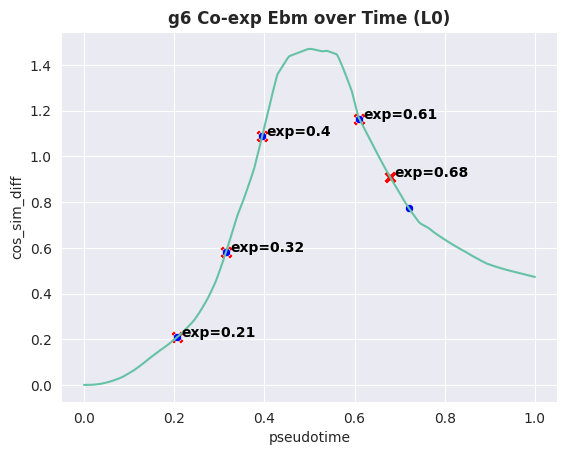

In [57]:
plot_change_point(df_time_series, 
title='{} Co-exp Ebm over Time (L{})'.format(gene, lineage))

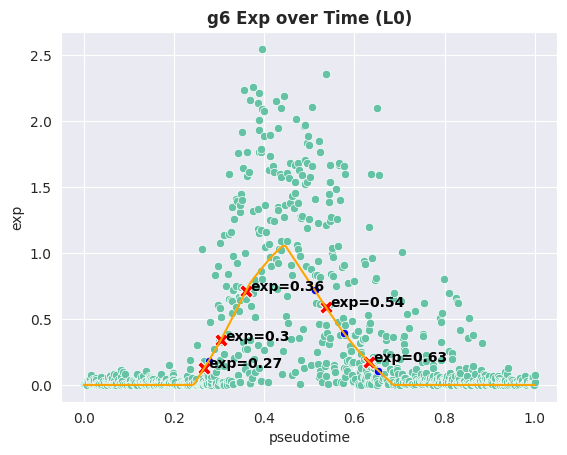

In [58]:
plot_exp_pred(df_time_series, 
df_exp,
title='{} Exp over Time (L{})'.format(gene, lineage))

In [59]:
def plot_exp_coexp(df_time_series, title):   
    sns.set_style("darkgrid")
    sns.set_palette("Set2")
    plt.figure()
    ax = sns.lineplot(
        x="pseudotime", 
        y="cos_sim_diff",
        data = df_time_series,
    )
    time_series = pd.DataFrame(df_time_series['cos_sim_diff'])
    algo = rpt.Pelt(model="rbf").fit(time_series)
    result = algo.predict(pen=10)
    ax = sns.scatterplot(
        x="pseudotime", 
        y="cos_sim_diff",
        data=df_time_series[df_time_series.index.isin(result)],
        marker="o",
        color="b"
    )

    algo = rpt.Binseg(model="l2").fit(time_series)
    my_bkps = algo.predict(n_bkps=5)
    ax = sns.scatterplot(
        x="pseudotime", 
        y="cos_sim_diff",
        data=df_time_series[df_time_series.index.isin(my_bkps)],
        marker="X",
        color="r",
        s=100,
    )

    temp = pd.DataFrame()
    temp['cos_time'] = df_time_series[df_time_series.index.isin(my_bkps)]['pseudotime'].sort_values().values

    ax = sns.lineplot(
        x="pseudotime", 
        y="exp_pred",
        data = df_time_series,
    )

    time_series = pd.DataFrame(df_time_series['exp_pred'])
    algo = rpt.Pelt(model="rbf").fit(time_series)
    result = algo.predict(pen=10)
    ax = sns.scatterplot(
        x="pseudotime", 
        y="exp_pred",
        data=df_time_series[df_time_series.index.isin(result)],
        marker="o",
        color="b"
    )

    algo = rpt.Binseg(model="l2").fit(time_series)
    my_bkps = algo.predict(n_bkps=5)
    ax = sns.scatterplot(
        x="pseudotime", 
        y="exp_pred",
        data=df_time_series[df_time_series.index.isin(my_bkps)],
        marker="X",
        color="r",
        s=100,
    )
    temp['exp_pred_time'] = df_time_series[df_time_series.index.isin(my_bkps)]['pseudotime'].sort_values().values
    pearson = round(df_time_series.corr().loc['cos_sim_diff', 'exp_pred'], 4)
    plt.text(np.mean(df_time_series['pseudotime']), 
        np.mean(df_time_series['exp_pred']), 
        'Pearson r = {}'.format(
            pearson
        ), 
        horizontalalignment='left', 
        size='medium', 
        color='black', 
        weight='semibold')
    dist = (np.linalg.norm(temp['exp_pred_time'].values-temp['cos_time'].values))
    dist = round(dist, 4)
    ax.set(ylabel='cos_sim_diff/exp_pred')
    plt.title(title, fontweight='semibold')
    return pearson
    

0.7486

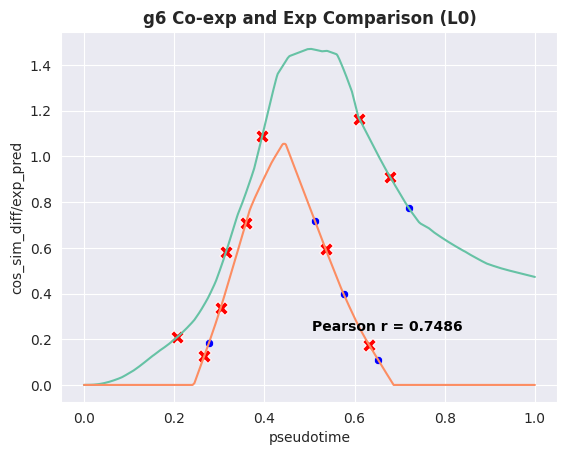

In [60]:
pearson = plot_exp_coexp(df_time_series, 
title='{} Co-exp and Exp Comparison (L{})'.format(gene, lineage))
pearson

In [61]:
pearson_list = []
for gene in df_vocab_DiffTime.gene:
    for lineage in [0] if dataset == 'LI' else [0, 1]:
        out_np_co_exp_c, time_DiffTime = get_DiffTime_output(model_DiffTime, gene=gene, lineage=lineage)
        exp_c, time_ExpEstimator = get_ExpEstimator_output(model_ExpEst, gene=gene, lineage=lineage)
        time_series_c = cos_time_series(out_np_co_exp_c)

        df_time_series = pd.DataFrame()
        df_time_series['pseudotime'] = time_DiffTime
        df_time_series['cos_sim_diff'] = time_series_c.tolist()[0]
        df_time_series['exp_pred'] = exp_c.flatten()
        df_time_series.dropna(inplace=True)
        
        pearson = round(df_time_series.corr().loc['cos_sim_diff', 'exp_pred'], 4)
        pearson_list.append(pearson)
    

In [62]:
pearson_list

[0.9009,
 0.9812,
 -0.2727,
 0.5542,
 0.7486,
 0.9764,
 0.9614,
 0.9797,
 -0.0512,
 0.2432,
 -0.1463,
 -0.1078,
 0.9064,
 0.5778]

In [543]:
np.save('/home/chloe/coexp_change/models/{}.npy'.format(dataset), np.array(pearson_list))

In [63]:
pearson_LI = np.load('/home/chloe/coexp_change/models/LI.npy')
pearson_TF = np.load('/home/chloe/coexp_change/models/TF.npy')
pearson_BF = np.load('/home/chloe/coexp_change/models/BF.npy')

In [73]:
sum(pearson_BF>0.5), len(pearson_BF)

(9, 14)

In [74]:
df_pearson_LI = pd.DataFrame()
df_pearson_LI['Pearson_r'] = pearson_LI.flatten()
df_pearson_LI['dataset'] = 'LI'
df_pearson_BF = pd.DataFrame()
df_pearson_BF['Pearson_r'] = pearson_BF.flatten()
df_pearson_BF['dataset'] = 'BF'
df_pearson_TF = pd.DataFrame()
df_pearson_TF['Pearson_r'] = pearson_TF.flatten()
df_pearson_TF['dataset'] = 'TF'

In [75]:
df_pearson = pd.concat([df_pearson_LI, df_pearson_BF, df_pearson_TF]).reset_index()

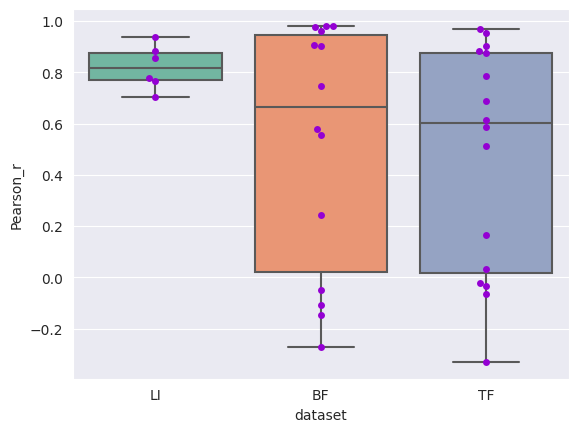

In [82]:
ax = sns.boxplot(data=df_pearson, x="dataset", y="Pearson_r")
ax = sns.swarmplot(data=df_pearson, x="dataset", y="Pearson_r", color='darkviolet')